<a href="https://colab.research.google.com/github/Louis5228/kv260-lane-following/blob/main/notebooks/lane_following_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customized CNN inference with google colab CPU/GPU
This notebook will take you to inference a 18 class CNN model.

## Import libraries

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets ,transforms

import os
import cv2
import time
import random
import numpy as np
import matplotlib.pyplot as plt

## Download dataset

In [61]:
!gdown --id 1AbVqa2KXUDwX7VuxTvpURR34uKzUbtxo -O Trail_dataset.zip
!unzip -o -q Trail_dataset.zip

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1AbVqa2KXUDwX7VuxTvpURR34uKzUbtxo
To: /content/Trail_dataset.zip
100% 397M/397M [00:01<00:00, 206MB/s]


## Download pretrained float-point model

In [62]:
!gdown --id 1MZ5cL5rm9Enknet5_mcJ9Ywyj1_FvSiY -O f_model.pth

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1MZ5cL5rm9Enknet5_mcJ9Ywyj1_FvSiY
To: /content/f_model.pth
100% 25.8M/25.8M [00:00<00:00, 249MB/s]


## Check if a GPU is available

In [63]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on device: {}\n".format(device))

!nvidia-smi

Running on device: cuda:0

Mon Apr 18 06:23:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    76W / 149W |    672MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                             

## CNN Network Definition



In [64]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()

        self.conv1 = nn.Sequential(              
            nn.Conv2d(
                in_channels=3,              
                out_channels=32,            
                kernel_size=4,              
                stride=1,                   
                padding=0,                  
            ),                                                 
            nn.MaxPool2d(kernel_size=2, stride=2),   
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels=32,
                out_channels=32,
                kernel_size=4,
                stride=1,
                padding=0,
            ),                           
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv3 = nn.Sequential(         
            nn.Conv2d(
                in_channels=32,
                out_channels=32,
                kernel_size=4,
                stride=1,
                padding=0,
            ),                           
            nn.MaxPool2d(kernel_size=2, stride=2),    
        )
        self.conv4 = nn.Sequential(         
            nn.Conv2d(
                in_channels=32,
                out_channels=32,
                kernel_size=4,
                stride=1,
                padding=0,
            ),                           
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc1 = nn.Linear(31968, 200)
        self.fc2 = nn.Linear(200, 18)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

## Load pretrained model (.pth)

In [65]:
# initial model and put it on device
model = CNN_Model().to(device)
# load pretrained model
model.load_state_dict(torch.load('f_model.pth', map_location=device))

print(model)

CNN_Model(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(4, 4), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(4, 4), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 32, kernel_size=(4, 4), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=31968, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=18, bias=True)
)


## Define utility functions

In [66]:
def BGR2RGB(image):
    B, G, R = cv2.split(image)
    image = cv2.merge([R, G, B])
    return image

def normalize(image):
    return np.asarray(image/255.0, dtype=np.float32)

def preprocess_fn(image):
    image = BGR2RGB(image)
    image = normalize(image)
    return image

## Prepare inference dataset

In [67]:
labels = []
image_path = []
total_images = 0

image_folder = 'Trail_dataset/test_data'
dirs = os.listdir(image_folder)
dirs.sort()
for d in dirs:
    labels.append(d)
    tmp_path = []
    dirs1 = os.listdir(image_folder + '/' + d)
    dirs1.sort()
    for d2 in dirs1:
        tmp_path.append(image_folder + '/' + d + '/' + d2)
    image_path.append(tmp_path)
    total_images += len(tmp_path)

print("Total number of test images: {}".format(total_images))
print("Dimension of each picture: {}x{}".format(cv2.imread(image_path[0][0]).shape[0], 
                                                cv2.imread(image_path[0][0]).shape[1]))
print("Labels: {}\n{}".format(len(labels), labels))

Total number of test images: 852
Dimension of each picture: 480x640
Labels: 18
['L_1', 'L_2', 'L_3', 'L_4', 'L_5', 'L_6', 'L_7', 'L_8', 'R_1', 'R_2', 'R_3', 'R_4', 'R_5', 'R_6', 'R_7', 'R_8', 'S_L', 'S_R']


## Evaluation
We make predictions over the entire test dataset and calculate accuracy and performance.

In [68]:
print("Evaluating {} images ...".format(total_images))
correct = 0

start = time.time()
for label in range(len(labels)):
    for image_index in range(len(image_path[label])):
        
        test_data = cv2.imread(image_path[label][image_index])
        input_data = preprocess_fn(test_data)
        input_data = np.expand_dims(input_data, axis=0).transpose(0, 3, 1, 2) ## convert HWC to CHW
        torch_x = torch.from_numpy(input_data).to(device)
        torch_y = torch.from_numpy(np.array(label)).to(device)

        with torch.no_grad():
          output = model(torch_x)
          _, predicted = torch.max(output.data, 1)
          correct += (predicted == torch_y).sum()

stop = time.time()
execution_time = stop - start
print("Overall accuracy: {:.2f}%".format((correct/total_images)*100))
print("  Execution time: {:.4f}s".format(execution_time))
print("     Performance: {:.4f}FPS".format(total_images/execution_time))

Evaluating 852 images ...
Overall accuracy: 85.09%
  Execution time: 10.0944s
     Performance: 84.4029FPS


## Randomly select a picture to predict

In [69]:
def runOnce(labels, image_path):

  label = random.randint(0, len(labels)-1)
  num_label_images = len(image_path[label])
  image_index = random.randint(0, num_label_images-1)
    
  start = time.time()

  test_data = cv2.imread(image_path[label][image_index])
  input_data = preprocess_fn(test_data)
  input_data = np.expand_dims(input_data, axis=0).transpose(0, 3, 1, 2) ## convert HWC to CHW
  torch_x = torch.from_numpy(input_data).to(device)
  torch_y = torch.from_numpy(np.array(label)).to(device)

  with torch.no_grad():
    output = model(torch_x)
    _, predicted = torch.max(output.data, 1)

  stop = time.time()
  execution_time = stop - start

  print("Image label: {}".format(labels[label]))
  print("Predicted label: {}".format(labels[predicted]))
  print("Execution time: {:.4f}s".format(execution_time))

  plt.imshow(cv2.cvtColor(test_data, cv2.COLOR_BGR2RGB))
  plt.show()

Image label: L_3
Predicted label: L_3
Execution time: 0.0172s


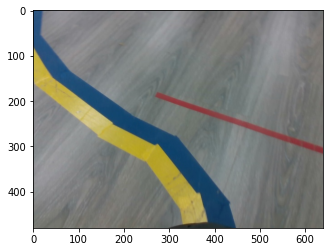

In [72]:
runOnce(labels, image_path)